In [1]:
import numpy as np
import pandas as pd
import missingno as msn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# EDA and Feature engineering

### Missing value detection

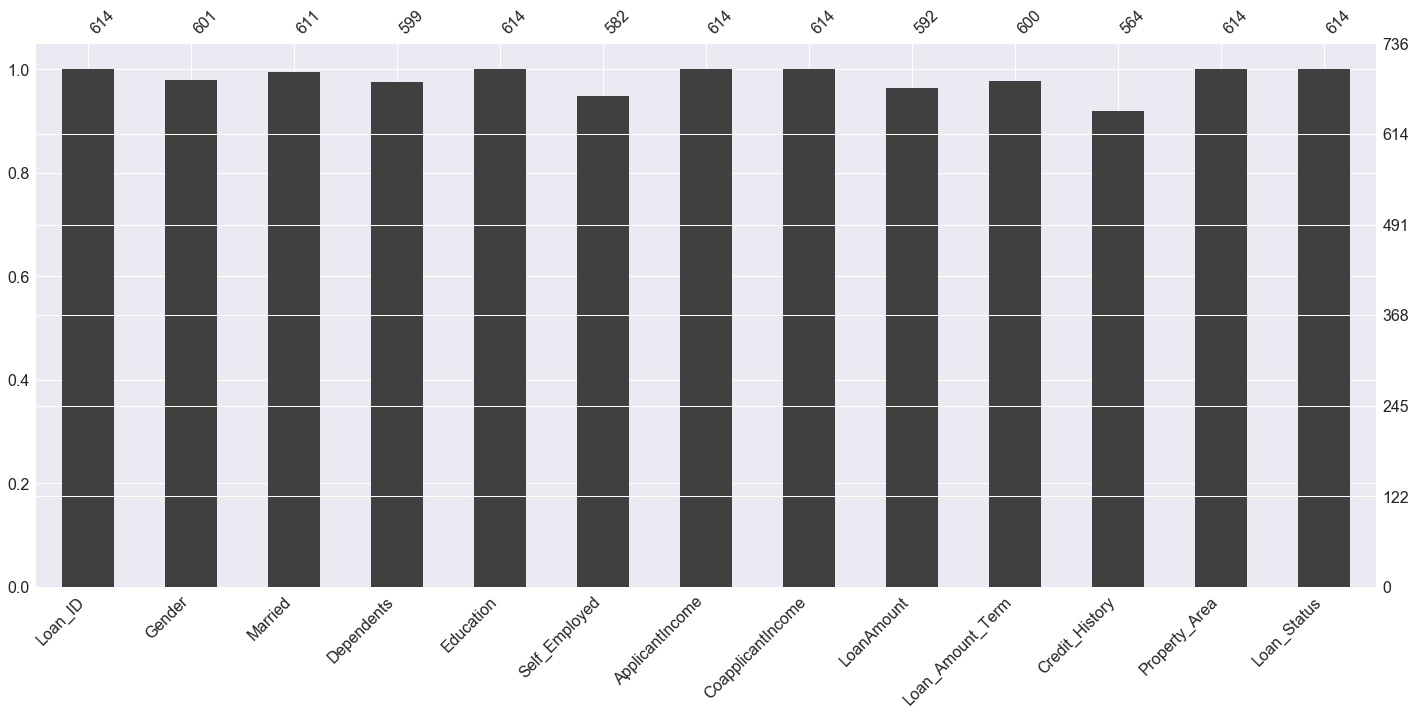

In [3]:
msn.bar(train_data)

Univariate analysis

In [4]:
train_data['Gender'].unique()

array(['Male', 'Female', nan], dtype=object)

In [5]:
train_data['Married'].unique()

array(['No', 'Yes', nan], dtype=object)

In [6]:
train_data['Dependents'].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

In [7]:
train_data['Self_Employed'].unique()

array(['No', 'Yes', nan], dtype=object)

In [8]:
train_data['Loan_Amount_Term'].unique()

array([ 360.,  120.,  240.,   nan,  180.,   60.,  300.,  480.,   36.,
         84.,   12.])

In [9]:
train_data['Credit_History'].unique()

array([  1.,   0.,  nan])

### Function for feature engineering

In [10]:
def preprocessing(df):
    # Missing value imputation
    df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
    df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
    df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
    df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
    df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
    df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])
    df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])
    
    # Encoding categorical variables
    df['Married'].replace(['Yes', 'No'], [1, 0], inplace = True)
    df['Education'].replace(['Graduate', 'Not Graduate'], [1, 0], inplace = True)
    df['Self_Employed'].replace(['Yes', 'No'], [1, 0], inplace = True)
    df['Dependents'].replace(['0', '1', '2', '3+'], [0, 1, 2, 3], inplace = True)
    df.drop('Loan_ID', axis = 1, inplace = True)
    return df

In [11]:
pred_df = pd.DataFrame({'Loan_ID': test_data['Loan_ID']})
train_data = preprocessing(train_data)
train_data['Loan_Status'].replace(['Y', 'N'], [1, -1], inplace = True)
test_data = preprocessing(test_data)
train_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,0,0,1,0,5849,0.0,146.412162,360.0,1.0,Urban,1
1,Male,1,1,1,0,4583,1508.0,128.000000,360.0,1.0,Rural,-1
2,Male,1,0,1,1,3000,0.0,66.000000,360.0,1.0,Urban,1
3,Male,1,0,0,0,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,Male,0,0,1,0,6000,0.0,141.000000,360.0,1.0,Urban,1


### Univariate plots

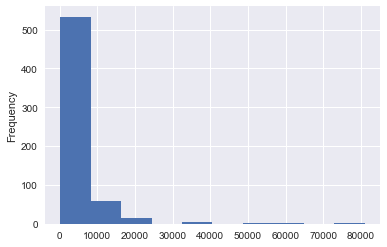

In [12]:
train_data['ApplicantIncome'].plot(kind = 'hist')

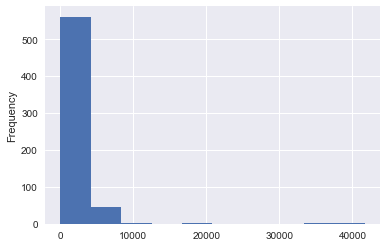

In [13]:
train_data['CoapplicantIncome'].plot(kind = 'hist')

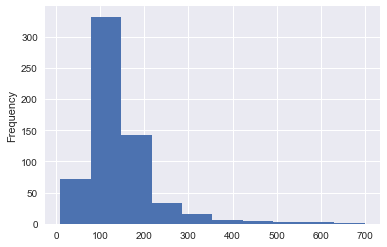

In [14]:
train_data['LoanAmount'].plot(kind = 'hist')

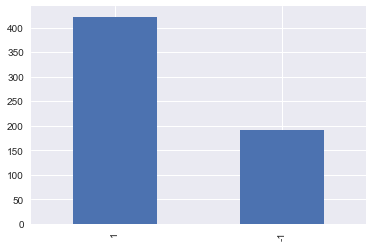

In [15]:
train_data['Loan_Status'].value_counts().plot(kind = 'bar')

In [16]:
# Function to transform continuous variables to have a normal distribution
def feature_transformation(df):
    df['ApplicantIncome'] = df['ApplicantIncome'] + 1
    df['ApplicantIncome'] = df['ApplicantIncome'].apply(lambda x: math.log(x))
    df['CoapplicantIncome'] = df['CoapplicantIncome'] + 1
    df['CoapplicantIncome'] = df['CoapplicantIncome'].apply(lambda x: math.log(x))
    df['LoanAmount'] = df['LoanAmount'].apply(lambda x: math.log(x))
    df['Credit_History'] = df['Credit_History'] * 10
    return df
train_data = feature_transformation(train_data)
test_data = feature_transformation(test_data)

In [17]:
train_data.shape

(614, 12)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:,0:11], 
                                                    train_data.iloc[:,11], 
                                                    test_size=0.2, 
                                                    random_state=41)

In [19]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
test_data = pd.get_dummies(test_data)

# Iteration 1: Using logistic regression

In [20]:
log_clf = LogisticRegression(random_state=42)
log_clf.fit(X_train, y_train)
prediction = log_clf.predict(X_test)
accuracy_score(y_test, prediction)

0.80487804878048785

In [21]:
# test_prediction = log_clf.predict(test_data)
# pred_df['Loan_Status'] = test_prediction
# pred_df.replace([1,-1], ['Y', 'N'], inplace = True)
# pred_df.to_csv("./loan_prediction.csv", header = True)

# Iteration 2: Using random forest classifier

In [22]:
rnd_clf = RandomForestClassifier(random_state = 42)
parameters = {'n_estimators': [32, 64], 
              'max_features': [None], 
              'criterion': ['gini'],
              'max_depth': [6], 
              'min_samples_split': [2, 3],
              'min_samples_leaf': [5, 6]
             }
grid_search = GridSearchCV(rnd_clf, parameters, scoring = make_scorer(accuracy_score))
grid_search.fit(X_train, y_train)
rnd_clf = grid_search.best_estimator_
rnd_clf.fit(X_train, y_train)
prediction = rnd_clf.predict(X_test)
accuracy_score(y_test, prediction)

0.80487804878048785

In [23]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 32}

In [24]:
# test_prediction = rnd_clf.predict(test_data)
# pred_df['Loan_Status'] = test_prediction
# pred_df.replace([1,-1], ['Y', 'N'], inplace = True)
# pred_df.to_csv("./loan_prediction.csv", header = True)

# Iteration 3: Using SVC

In [25]:
svm_clf = SVC(C = 1.5, probability = True, random_state=42)
svm_clf.fit(X_train, y_train)
prediction = svm_clf.predict(X_test)
accuracy_score(y_test, prediction)

0.81300813008130079

In [26]:
# test_prediction = svm_clf.predict(test_data)
# pred_df['Loan_Status'] = test_prediction
# pred_df.replace([1,-1], ['Y', 'N'], inplace = True)
# pred_df.to_csv("./loan_prediction.csv", header = True)

# Iteration 4: Using voting classifier with logistic regression, random forest classifier and SVC as base model

In [27]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')
voting_clf.fit(X_train, y_train)
prediction = voting_clf.predict(X_test)
accuracy_score(y_test, prediction)

0.80487804878048785

In [28]:
# test_prediction = voting_clf.predict(test_data)
# # pred_df['Loan_Status'] = test_prediction
# pred_df.replace([1,-1], ['Y', 'N'], inplace = True)
# pred_df.to_csv("./loan_prediction.csv", header = True)

# Iteration 4: Using AdaBoost

In [29]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 6, random_state = 42,), 
                             n_estimators=200,algorithm="SAMME.R", learning_rate = 1,
                             random_state = 42)
ada_clf.fit(X_train, y_train)
prediction = ada_clf.predict(X_test)
accuracy_score(y_test, prediction)

0.78048780487804881

In [30]:
# test_prediction = ada_clf.predict(test_data)
# pred_df['Loan_Status'] = test_prediction
# pred_df.replace([1,-1], ['Y', 'N'], inplace = True)
# pred_df.to_csv("./loan_prediction.csv", header = True)

# Iteration 5: Using gradient boosting classifier

In [31]:
gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
parameters = {'n_estimators': [2, 32, 64],
              'max_depth': [2, 4, 6], 
              'learning_rate': [0.1, 0.2, 0.5, 1],
              'min_samples_split': [2, 6],
              'max_features': ['auto'],
              'min_samples_leaf': [4, 6]
             }
grid_search = GridSearchCV(gb_clf, parameters, scoring = make_scorer(accuracy_score))
grid_search.fit(X_train, y_train)
gb_clf = grid_search.best_estimator_
gb_clf.fit(X_train, y_train)
prediction = gb_clf.predict(X_test)
accuracy_score(y_test, prediction)

0.80487804878048785

In [32]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 32}

In [33]:
# test_prediction = gb_clf.predict(test_data)
# pred_df['Loan_Status'] = test_prediction
# pred_df.replace([1,-1], ['Y', 'N'], inplace = True)
# pred_df.to_csv("./loan_prediction.csv", header = True)